In [42]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.Session(config=config)

import numpy as np
from PIL import Image
from keras import callbacks
from keras.layers import Conv2D, BatchNormalization, Input, Activation, UpSampling2D, Lambda
from keras.layers.convolutional import Deconv2D
from keras.layers.merge import add
from keras.models import Model
from keras import backend as K
from vgg16_avg import VGG16_Avg
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.model_selection import train_test_split

%matplotlib inline

In [43]:
params = {'verbose': 0, 'callbacks': []}
lr_img_dir = 'data/lr_images/'
hr_img_dir = 'data/hr_images/'
fnames = os.listdir('data/mirflickr/')

lr_dims = (72, 72, 3) # Number of channels is last dim with tf backend
hr_dims = (288, 288, 3)

In [45]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, kernel_size=(size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return add([x, ip]) # Adding the transformed feature map with the original input (residual connection)

def deconv_block(x, filters, size, stride=(2,2)):
    x = Deconv2D(filters, kernel_size=(size, size), strides=stride, 
        padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, kernel_size=(size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

inp = Input(shape=lr_dims)
x = conv_block(inp, 64, 9, (1,1))
for i in range(4): 
    x = res_block(x)
x = up_block(x, 64, 3) # Try up-sampling vs. deconv instead (deconv might produce checkerboard patterns)
x = up_block(x, 64, 3)
x = Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
outp = Lambda(lambda x: (x+1)*127.5)(x) # +1 since tanh gives values between -1 and 1, and we need to scale to 0

base_model = Model(inputs=inp, outputs=outp)
base_model.load_weights('saved_models/sr_upsampling_epoch_2_weights.h5')
base_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 72, 72, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 72, 72, 64)   256         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 72, 72, 64)   0           batch_normalization_34[0][0]     
____________________________________________________________________________________________

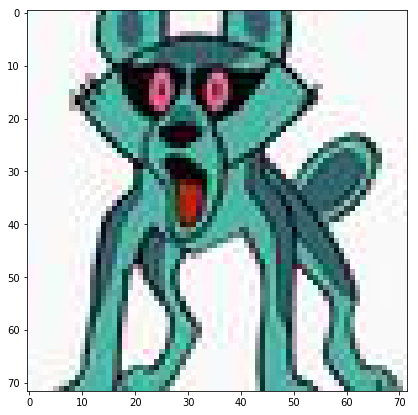

In [85]:
# Original LR image 72x72
# testimage = Image.open('data/0.jpg')
testimage = Image.open('data/lr_images/im004.jpg')
plt.figure(figsize=(7,7))
plt.imshow(testimage)
# plt.imsave('images/results/upsampling/lr72x72.jpg', lr_img_array_test[k])

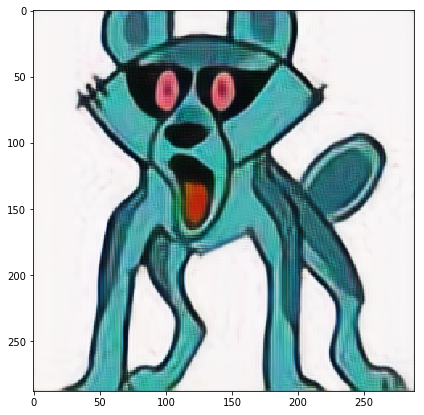

In [86]:
image_fhr_1 = base_model.predict(np.array([np.array(testimage.resize((72, 72)))]), batch_size=1)[0]

plt.figure(figsize=(7,7))
plt.imshow(image_fhr_1.astype('uint8'))

In [ ]:

# plt.imsave(r'C:\Users\vandryushechkin\Desktop\1.jpg', np.array(testimage))
# plt.imsave(r'C:\Users\vandryushechkin\Desktop\2.jpg', image_fhr_1.astype('uint8'))
# plt.imsave(r'data/im002_a.jpg', image_fhr_1.astype('uint8'))

In [76]:
def copy_weights(from_layers, to_layers):
    for from_layer,to_layer in zip(from_layers, to_layers):
        to_layer.set_weights(from_layer.get_weights())
        
def get_model(input_shape):
    inp=Input(input_shape)
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

inp,outp = get_model(hr_dims)
model_hr = Model(inp, outp)
copy_weights(base_model.layers, model_hr.layers)

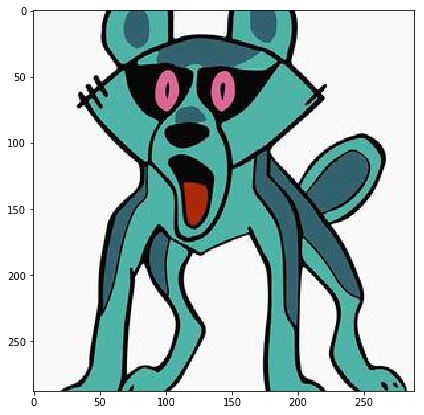

In [87]:
# testimage = Image.open('data/0.jpg')
testimage = Image.open('data/hr_images/im004.jpg')

plt.figure(figsize=(7,7))
plt.imshow(testimage)

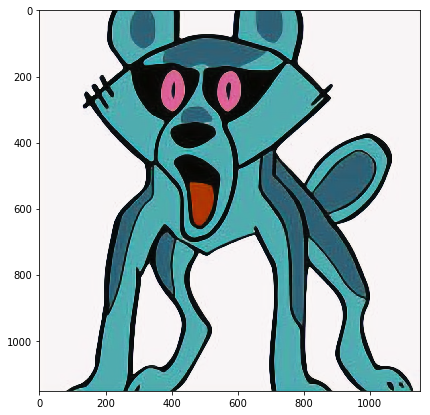

In [88]:
image_fhr_2 = model_hr.predict(np.array([np.array( testimage.resize((288, 288)) )]))[0]

plt.figure(figsize=(7,7))
plt.imshow(image_fhr_2.astype('uint8'))

In [69]:
# plt.imsave(r'C:\Users\vandryushechkin\Desktop\3.jpg', np.array(testimage))
# plt.imsave(r'C:\Users\vandryushechkin\Desktop\4.jpg', image_fhr_2.astype('uint8'))